# Проект: Определение стоимости автомобилей

__Заказчик__: сервис по продаже автомобилей с пробегом «Не бит, не крашен»

__Цель проекта__: построение модели для предсказания стоимости автомобиля

__Данные__: технические характеристики, комплектации и цены автомобилей
    
__Оценка модели__:
- метрика RMSE (должно быть меньше 2500)

__Критерии, которые важны заказчику__:
- качество предсказания;
- время предсказания модели;
- время обучения модели.

## Подготовка данных

In [ ]:
#!pip install -q phik

In [ ]:
# импорты
from time import time
import warnings

import datetime as dt
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

# отключение предупреждений
warnings.filterwarnings("ignore", category=UserWarning)

# константы
TEST_SIZE = 0.25
TITLE_SIZE = 16
LABEL_SIZE = 14
RANDOM_STATE = 42

### Загрузка данных

In [ ]:
data = pd.read_csv('/datasets/cars.csv',
                       parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [7]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Всего в датасете 354369 записей. В некоторых столбцах есть пропуски. Запишем названия столбцов в змеином регистре.

In [8]:
data = data.rename(columns={'DateCrawled': 'date_crawled',
                            'Price': 'price',
                            'VehicleType': 'vehicle_type',
                            'RegistrationYear':'registration_year',
                            'Gearbox': 'gearbox',
                            'Power': 'power',
                            'Model': 'model',
                            'Kilometer': 'kilometer',
                            'RegistrationMonth': 'registration_month',
                            'FuelType': 'fuel_type',
                            'Brand': 'brand',
                            'Repaired': 'repaired',
                            'DateCreated': 'date_created',
                            'NumberOfPictures': 'number_of_pictures',
                            'PostalCode': 'postal_code',
                            'LastSeen': 'last_seen'
                           })
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Предобработка данных

Создадим копию датасета до обработки пропущенных и аномальных значений для контроля изменения размерности.

In [9]:
temp = data.copy()

Изучим пропущенные значения.

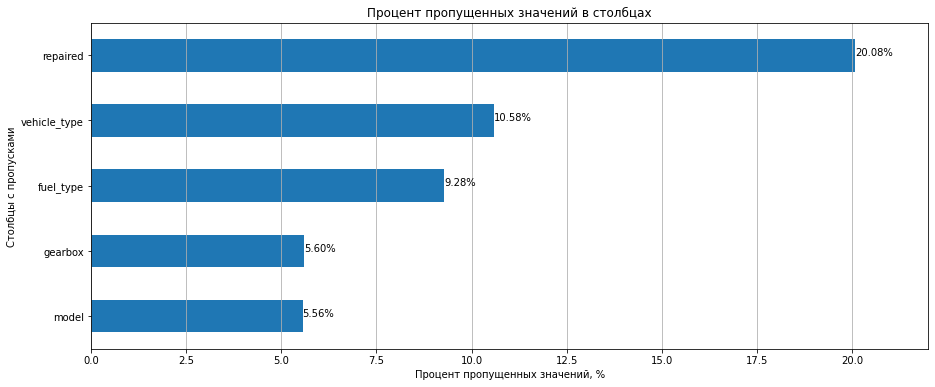

In [10]:
ax = (
    (data.isna().mean() * 100)
    .to_frame()
    .rename(columns={0: 'percentage_of_missing_values'})
    .query('percentage_of_missing_values > 0')
    .sort_values(by='percentage_of_missing_values')
    .plot(kind='barh', figsize=(15, 6),
          title='Процент пропущенных значений в столбцах', legend=False, xlim=(0, 22))
)
ax.grid(axis='x')
ax.set(xlabel='Процент пропущенных значений, %', ylabel='Столбцы c пропусками');

# Добавление меток к столбцам с коррекцией координат для избежания перекрытия
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', ((p.get_width()), p.get_y() + p.get_height() / 2))

plt.show()

Пропущенных значений довольно много, поэтому мы не можем их просто удалить. В целевом признаке пропусков нет.

Признаки с пропущенными значениями являются важными характеристиками, которыми обычно интересуются покупатели. Логично предположить, что они будут оказывать влияние на целевой признак. Лучшей стратегией для заполнения пропусков в категориальных признаках выглядит использование значения по умолчанию. 

In [11]:
columns_to_replace = ['repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']
for column in columns_to_replace:
    data[column] = data[column].fillna('unknown')
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Проверим данные на явные дубликаты.

In [12]:
data.duplicated().sum()

4

Удалим найденные дубликаты.

In [13]:
data = data.drop_duplicates()
data.shape[0] / temp.shape[0]

0.9999887123309319

Поищем неявные дубликаты по признакам, непосредственно связанным с характеристиками машины, и по ее стоимости. 

In [14]:
columns = ['price',
           'vehicle_type',
           'registration_year',
           'gearbox',
           'power',
           'model',
           'kilometer',
           'fuel_type',
           'brand',
           'repaired']
data.duplicated(columns).sum() / temp.shape[0]

0.1270878660379435

Неявных дубликатов 12.7%, удалим их.

In [15]:
data = data.drop_duplicates(subset=columns, keep='first')
data.shape[0] / temp.shape[0]

0.8729008462929884

### Исследовательский анализ данных

In [16]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных
     признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """

    median = data[column].median()
    mean = data[column].mean()

    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)

    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5,
                  label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"',
                    fontsize=TITLE_SIZE)

    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [17]:
def analyze_discrete_data(data, column, title):
    """
    Функция помогает при проведении статистического анализа дискретных численных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.

    Выводит для колонки:
    - описание данных
    - график частот
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
        
    # Создаем фигуру и оси
    fig, ax = plt.subplots(2, 1, figsize=(17, 12))

    # График частот
    sns.countplot(x=data[column], ax=ax[0], palette='Blues')
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(False)
    # Добавление значений на столбцах
    for p in ax[0].patches:
        ax[0].annotate(f'{p.get_height():.0f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       fontsize=12, color='black',
                       xytext=(0, 5), textcoords='offset points')

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [18]:
def analyze_categorical_data(data, column):
    """
    Функция используется при анализе категориальных данных.
    Выводит на экран информацию:
    - название столбца,
    - число уникальных значений и уникальные значения,
    - сгруппированную таблицу с числом записей, 
    процентом от общего числа,
    медианным значением авто для каждой группы
 
    Params:
    data - датафрейм
    column - столбец для анализа

    Returns:
    grouped_data - сгруппированные по столбцу column данные
    min_median_row
    max_median_row
    """

    grouped_data = (
        data
        .groupby(column)
        .agg(
            count=('price', 'count'),
            percent=('price', lambda x: 100 * x.count() / data.shape[0]),
            median=('price', 'median')
        )
        .sort_values(by='count', ascending=False)
    )
    unique_values = data[column].unique()
    print(f'Столбец {column}\n')
    print(f'Число уникальных значений: {data[column].nunique()}')
    print(f'Уникальные значения {data[column].unique()}\n')
    print(grouped_data, '\n')
    min_median_row = grouped_data[grouped_data['median'] == grouped_data['median'].min()]
    max_median_row = grouped_data[grouped_data['median'] == grouped_data['median'].max()]
    print(f'Минимальная медианная стоимость:')
    print(min_median_row)
    print('Максимальная медианная стоимость:')
    print(max_median_row)

Датасет содержит 16 признаков.

Неинформативные признаки:
- date_crawled
- date_created
- last_seen
- postal_code
- registration_month

На первый взгляд не должны влиять, но т.к. дает дополнительную информацию о состоянии автомобиля (наличие фото может оказать влияние на стоимость непосредственно в приложении), стоит проверить влияние:
- number_of_pictures — количество фотографий автомобиля

Числовые признаки:
- registration_year — год регистрации автомобиля
- power — мощность (л.с.)
- kilometer — пробег (км)

Категориальные признаки:
- vehicle_type — тип автомобильного кузова
- gearbox — тип коробки передач
- model — модель автомобиля
- fuel_type — тип топлива
- brand — марка автомобиля
- repaired — была машина в ремонте или нет

Целевой признак: 
- price

Отметим, что к анализу мы приступаем с 87,3% от изначальных данных.

__Неинформативные для модели признаки__

In [19]:
for column in ['date_crawled', 'date_created']:
    print(f'Column: {column}\n min: {data[column].min()}\n max: {data[column].max()}')

Column: date_crawled
 min: 2016-03-05 14:06:24
 max: 2016-04-07 14:36:58
Column: date_created
 min: 2014-03-10 00:00:00
 max: 2016-04-07 00:00:00


Датасет содержит данные, собранные с 10.03.2014 по 07.04.2016, данные были выгружены в период с 05.03.2016 по 07.04.2016 год. 

Эти признаки (date_crawled, date_created), а также registration_month, last_seen и postal_code, определенно не оказывают влияние на стоимость автомобиля. Не будем их использовать.

In [20]:
data = data.drop(['date_crawled', 'date_created', 'last_seen',
                  'postal_code', 'registration_month'], axis=1)
data.shape

(309329, 11)

__price (целевой признак)__

In [21]:
data['price'].describe()

count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

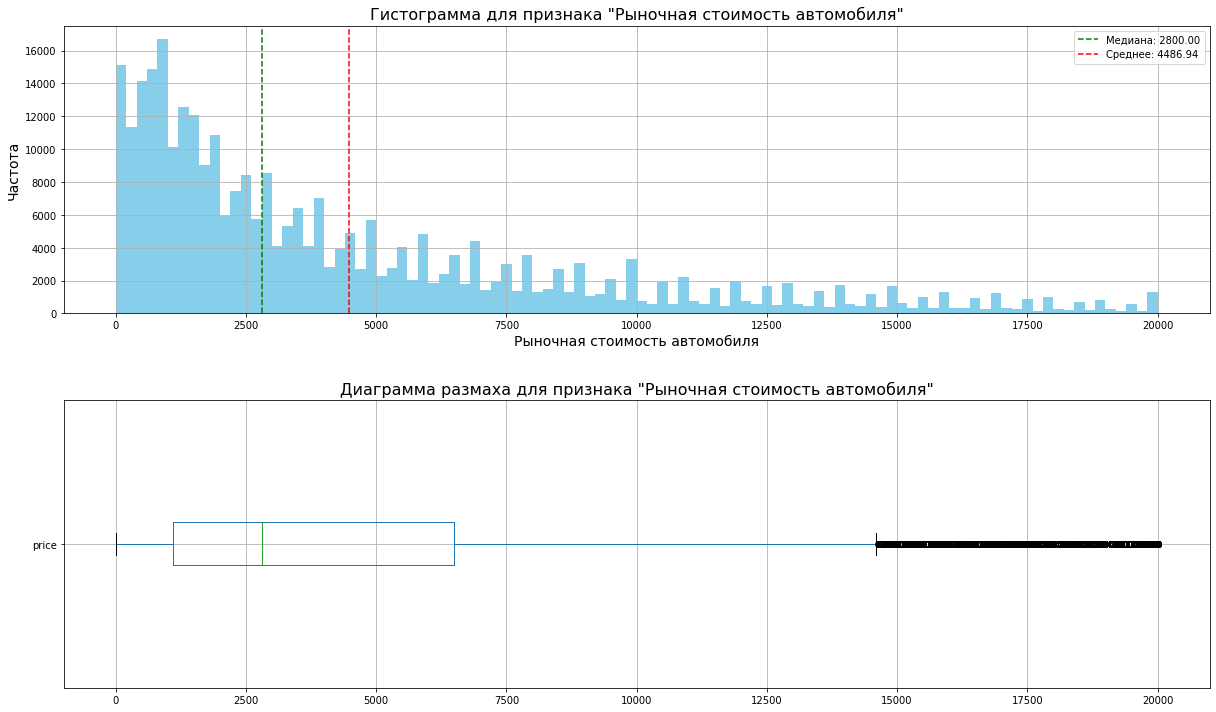

In [22]:
analyze_numerical_data(data, 'price', 'Рыночная стоимость автомобиля')

Стоимость машин, равная 0, явно является аномалией. Удалим такие записи. 

In [23]:
data[data['price'] == 0].shape[0] / temp.shape[0]

0.025126351345631247

In [24]:
data = data.drop(data[(data['price'] == 0)].index)
data.shape[0] / temp.shape[0]

0.8477744949473571

In [25]:
data[data['price'] < 1000].shape[0] / temp.shape[0]

0.17870919860371534

In [26]:
data[data['price'] < 500].shape[0] / temp.shape[0]

0.06524272721372355

In [27]:
# оставим только те автомобили, цена которых больше 500 евро
data = data[data['price'] > 500]

__Категориальные данные__

In [28]:
analyze_categorical_data(data, 'vehicle_type')

Столбец vehicle_type

Число уникальных значений: 9
Уникальные значения ['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'unknown'
 'other']

              count    percent  median
vehicle_type                          
sedan         71747  26.314207    3500
small         55933  20.514203    2179
wagon         51509  18.891640    3600
bus           24789   9.091709    4444
unknown       24764   9.082540    1999
convertible   17483   6.412133    5800
coupe         13310   4.881627    4650
suv           10498   3.850287    8500
other          2622   0.961655    2850 

Минимальная медианная стоимость:
              count  percent  median
vehicle_type                        
unknown       24764  9.08254    1999
Максимальная медианная стоимость:
              count   percent  median
vehicle_type                         
suv           10498  3.850287    8500


Число уникальных значений признака vehicle_type - 8. Чаще всего встречаются значения 'sedan',
'small', 'wagon'. Наибольшая медианная стоимость у авто с кузовом 'suv' - 8500, наименьшая - 2179, кузов 'small'.

In [29]:
analyze_categorical_data(data, 'gearbox')

Столбец gearbox

Число уникальных значений: 3
Уникальные значения ['manual' 'auto' 'unknown']

          count    percent  median
gearbox                           
manual   205092  75.220333    3000
auto      56247  20.629367    5800
unknown   11316   4.150300    2000 

Минимальная медианная стоимость:
         count  percent  median
gearbox                        
unknown  11316   4.1503    2000
Максимальная медианная стоимость:
         count    percent  median
gearbox                          
auto     56247  20.629367    5800


Количество машин с ручной коробкой передач в несколько раз превышает количество машин с автоматической. При этом медианная стоимость машин с автоматической коробкой передач почти в 2 раза превышает стоимость машин с ручной коробкой передач.

In [30]:
analyze_categorical_data(data, 'model')

Столбец model

Число уникальных значений: 251
Уникальные значения ['unknown' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'c4'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'other'
 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'polo'
 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' 'escort' 'forester'
 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt' 'a6' 'jazz'
 'slk' '7er' '80' '147' 'z_reihe' 'sportage' 'sorento' 'ibiza' 'mustang'
 'eos' 'touran' 'getz' 'a3' 'ka' 'almera' 'megane' 'lupo' 'zafira' 'caddy'
 'corsa' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan'
 'i_reihe' 'espace' 'sharan' '6_reihe' 'panda' 'up' 'seicento' 'ceed'
 '5_reihe' 'yeti' 'octavia' 'mii' 'rx_reihe' '6er' 'modus' 'fox' 'matiz'
 'beetle' 'c1' 'rio' 'touareg' 'logan' 'spider' 'omega' 'cuore' 's_max'
 'a2' 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe' 'avensis' 'roomster' 's

In [31]:
sorted(data['model'].dropna().unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Медианная стоимость различных моделей предсказуемо различается - от 775 до 18999. Удалось заметить один неявный дубликат, избавимся от него.

In [32]:
data['model'] = data['model'].replace('rangerover', 'range_rover') 

In [33]:
analyze_categorical_data(data, 'fuel_type')

Столбец fuel_type

Число уникальных значений: 8
Уникальные значения ['gasoline' 'petrol' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']

            count    percent  median
fuel_type                           
petrol     163520  59.973226    2790
gasoline    82058  30.095909    5500
unknown     21599   7.921733    1990
lpg          4575   1.677945    3100
cng           490   0.179714    3900
hybrid        212   0.077754   10850
other         119   0.043645    2350
electric       82   0.030075    5935 

Минимальная медианная стоимость:
           count   percent  median
fuel_type                         
unknown    21599  7.921733    1990
Максимальная медианная стоимость:
           count   percent  median
fuel_type                         
hybrid       212  0.077754   10850


In [34]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol') 

Дороже всего гибриды, их медианная стоимость - 10850, однако их количество менее 1%. Стоит отметить, что petrol и gasoline - один и тот же вид топлива, поэтому мы осуществили замену 'gasoline' на 'petrol'.

In [35]:
analyze_categorical_data(data, 'brand')

Столбец brand

Число уникальных значений: 40
Уникальные значения ['audi' 'jeep' 'volkswagen' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'citroen' 'honda' 'fiat' 'mini'
 'smart' 'hyundai' 'seat' 'subaru' 'volvo' 'mitsubishi' 'alfa_romeo' 'kia'
 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia' 'sonstige_autos'
 'daihatsu' 'chrysler' 'jaguar' 'daewoo' 'rover' 'porsche' 'saab'
 'trabant' 'land_rover' 'lada']

                count    percent  median
brand                                   
volkswagen      56258  20.633401    3499
bmw             29486  10.814399    5500
opel            27695  10.157525    2100
mercedes_benz   27412  10.053731    4500
audi            23617   8.661862    5400
ford            18167   6.662999    2300
renault         12728   4.668170    1700
peugeot          8659   3.175808    2550
fiat             7046   2.584218    2200
seat             5405   1.982359    3250
skoda            4763   1.746896    4999
smart            4665

Неявных дубликатов не выявлено. Медианная стоимость самого дорогого бренда porsche составляет 12475, что в 10.8 раз превышает стоимость самого дешевого бренда.

In [36]:
analyze_categorical_data(data, 'repaired')

Столбец repaired

Число уникальных значений: 3
Уникальные значения ['yes' 'unknown' 'no']

           count    percent  median
repaired                           
no        201111  73.760246    4000
unknown    48634  17.837194    2100
yes        22910   8.402560    1500 

Минимальная медианная стоимость:
          count  percent  median
repaired                        
yes       22910  8.40256    1500
Максимальная медианная стоимость:
           count    percent  median
repaired                           
no        201111  73.760246    4000


Машины, которые не были в ремонте, в несколько раз дороже отремонтированных. В нашем датасете 73.76% машин не были в ремонте согласно анкетам.

__Числовые признаки__

In [37]:
data[['power', 'kilometer', 'number_of_pictures', 'registration_year']].describe()

,power,kilometer,number_of_pictures,registration_year
count,272655.000000,272655.000000,272655.0,272655.000000
mean,116.512153,126772.844804,0.0,2004.360356
std,200.047866,37971.490208,0.0,68.042345
min,0.000000,5000.000000,0.0,1000.000000
25%,75.000000,125000.000000,0.0,2000.000000
50%,109.000000,150000.000000,0.0,2004.000000
75%,149.000000,150000.000000,0.0,2008.000000
max,20000.000000,150000.000000,0.0,9999.000000


Признак 'number_of_pictures' неинформативный, содержит только нули. Удалим его.

In [38]:
data = data.drop('number_of_pictures', axis=1)
data.shape

(272655, 10)

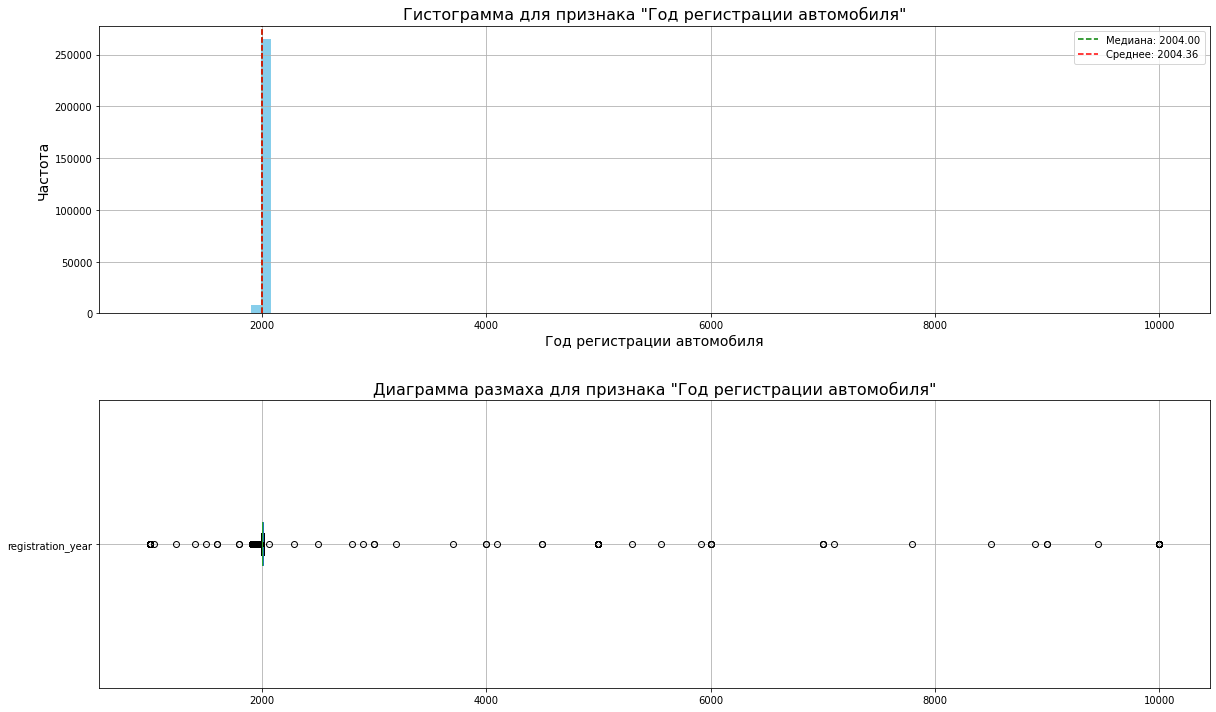

In [39]:
analyze_numerical_data(data, 'registration_year', 'Год регистрации автомобиля')

Значения признака 'registration_year' находятся в диапазоне от 1000 до 9999. Многие значения явно не соответствуют действительности.

In [40]:
# сколько записей с момента появления регистрационных номеров до даты выгрузки
data[(data['registration_year'] > 1901) & (data['registration_year'] < 2017)].shape[0] / temp.shape[0]

0.7354057493742399

In [41]:
data = data[(data['registration_year'] > 1901) & (data['registration_year'] < 2017)]
data.shape[0] / temp.shape[0]

0.7354057493742399

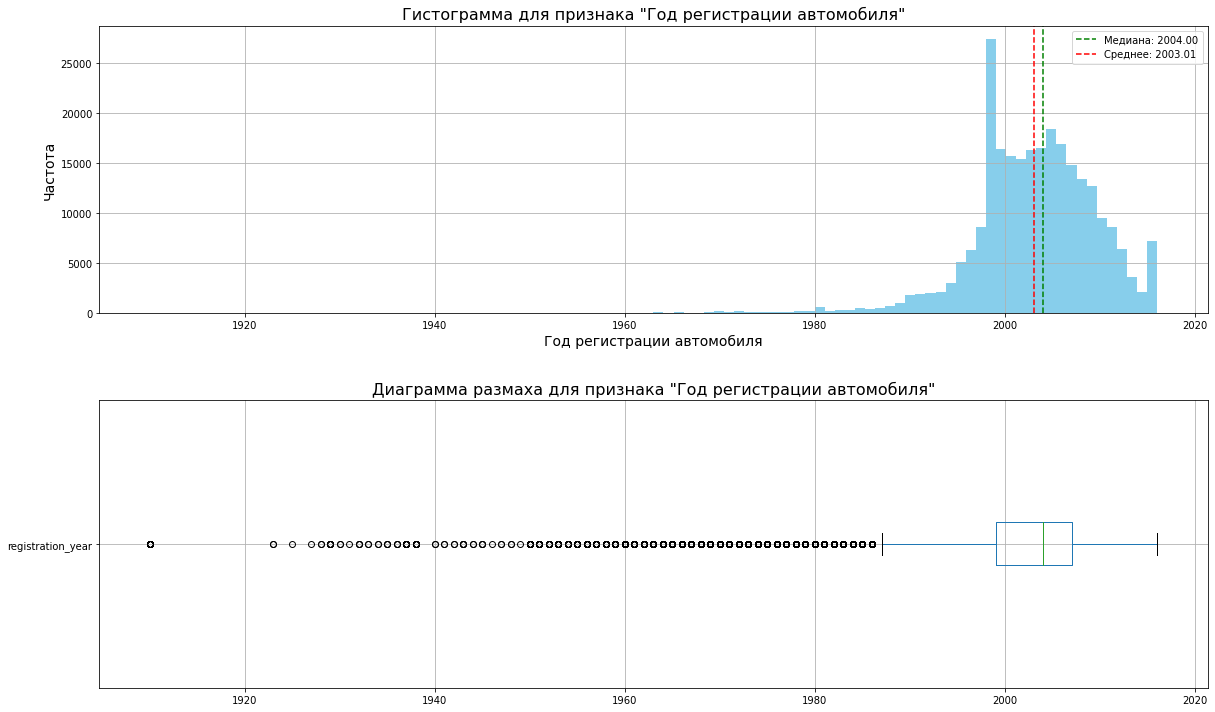

In [42]:
analyze_numerical_data(data, 'registration_year', 'Год регистрации автомобиля')

Чтобы сделать выборку более однородной, удалим также значения меньше 1985.

In [43]:
data[data['registration_year'] >= 1985].shape[0] / temp.shape[0]

0.7229300531367021

In [44]:
data = data[data['registration_year'] >= 1985]

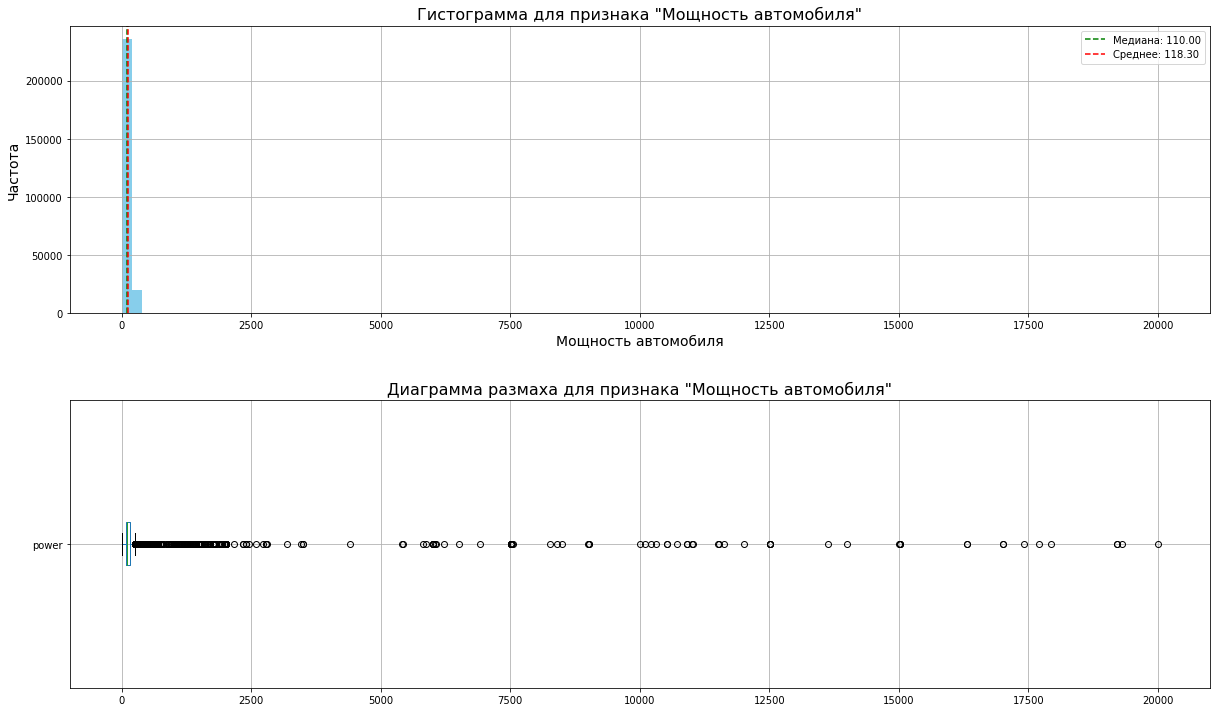

In [45]:
analyze_numerical_data(data, 'power', 'Мощность автомобиля')

In [46]:
Q1 = data['power'].quantile(0.25)
Q3 = data['power'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
upper_bound

262.5

In [47]:
data[(data['power'] > 0) & (data['power'] <= upper_bound)].shape[0] / temp.shape[0]

0.6480109716143342

In [48]:
data[(data['power'] >= 30) & (data['power'] <= 1000)].shape[0] / temp.shape[0]

0.6618073251328418

В качестве верхней границы возьмем 1000 л.с. Также удалим записи, где мощность авто меньше 30 л.с.

__Стоит отметить, что в данных очень много выбросов и аномалий__, из-за чего мы теряем большой процент данных. Вместе с тем, учитывая относительно большой размер датасета, это поможет повысить качество данных.

In [49]:
data = data[(data['power'] >= 30) & (data['power'] <= 1000)]
data.shape[0] / temp.shape[0]

0.6618073251328418

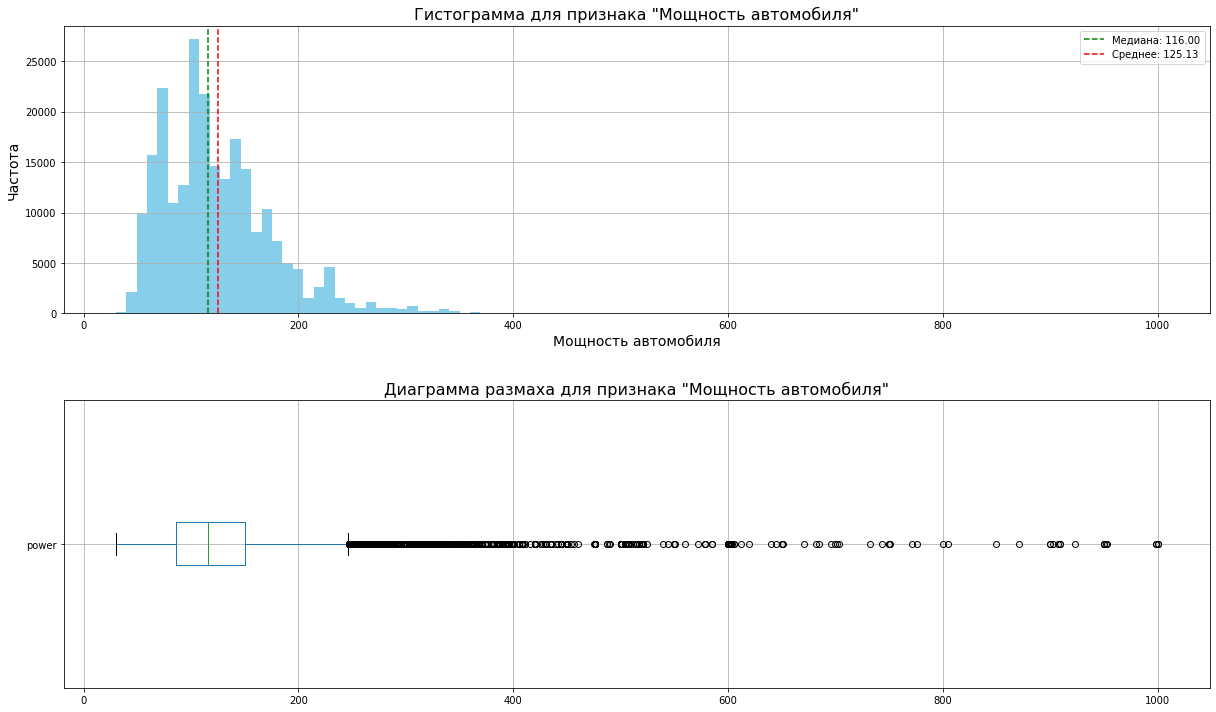

In [50]:
analyze_numerical_data(data, 'power', 'Мощность автомобиля')

Рассмотрим признак 'kilometer' как дискретный.

In [51]:
data['kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,  20000,
        80000,   5000,  50000,  40000,  10000])

Пробег автомобиля


count    234524.000000
mean     126890.488820
std       37272.545207
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

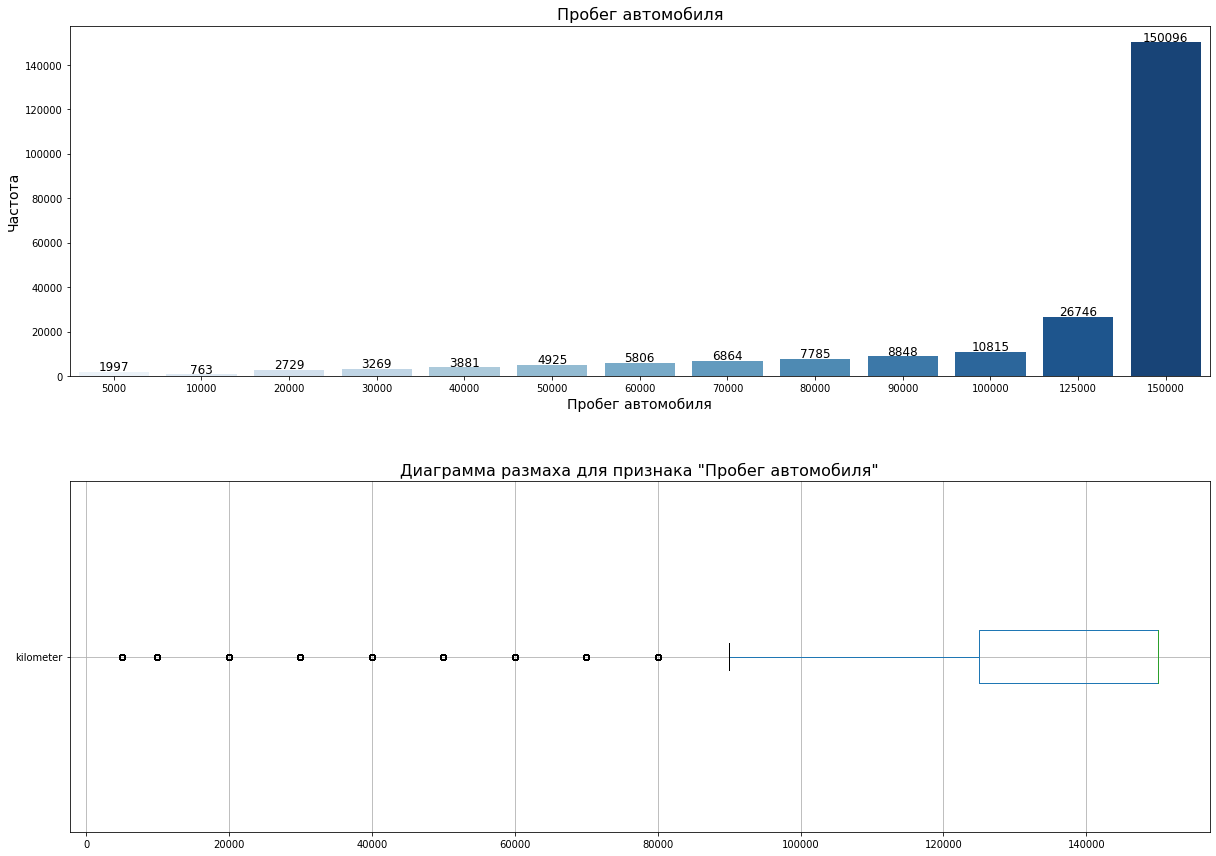

In [52]:
analyze_discrete_data(data, 'kilometer', 'Пробег автомобиля')

Низкие значения пробега являются редкими, не являются аномальными. 

In [53]:
data.shape

(234524, 10)

In [54]:
data.shape[0] / temp.shape[0]

0.6618073251328418

После удаления неявных дубликатов, аномалий и выбросов __размер датасета сократился на 33.8% и составляет 234524 записи, 10 признаков.__

In [55]:
del temp

Изучим __матрицу корреляции__ между признаками.

In [56]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

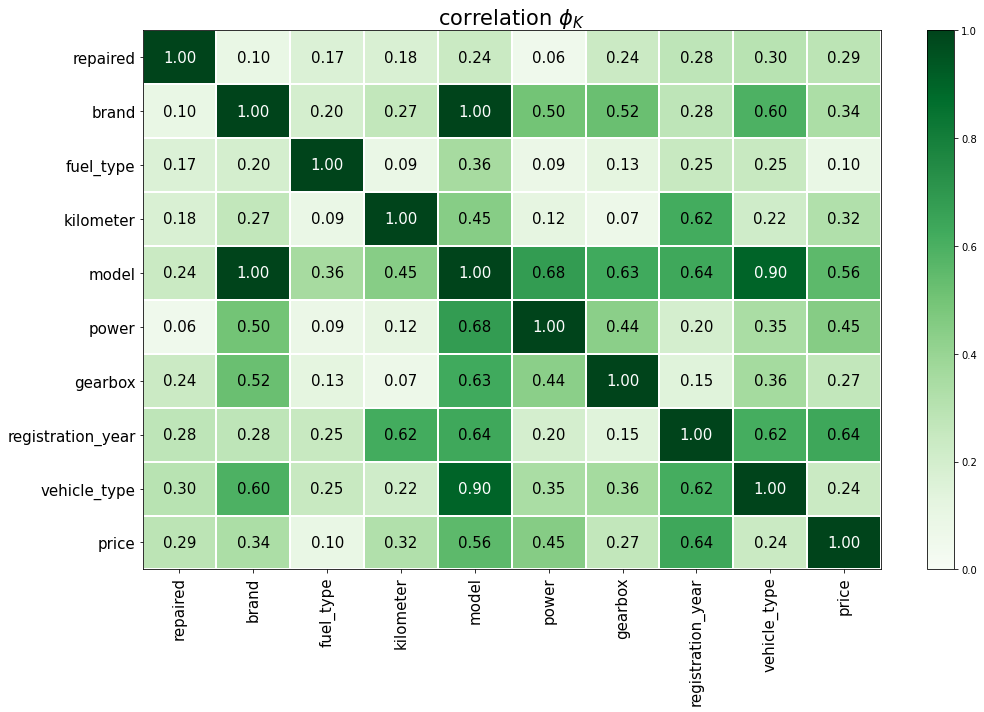

In [57]:
phik_overview = phik_matrix(data, interval_cols=['price', 'power']) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

Видим мультиколлинеарность между брендом и моделью, однако будем учитывать оба признака, т.к. оба признака влияют на стоимость.

Все отобранные нами признаки имеют взаимосвязь с целевым:
- заметная (model,  registration_year)
- умеренная (power, brand, kilometer)
- слабая (repaired, fuel_type, vehicle_type, gearbox)

__Промежуточный вывод__:
- загрузили данные, распарсив при этом даты;
- данные соответствуют описанию;
- привели названия столбцов к змеиному регистру;
- удалили явные и неявные дубликаты, выбросы и аномальные значения;
- удалили неинформативные признаки;
- размер датасета сократился на 33.8% и составляет 234524 записи, 10 признаков;
- корреляционная матрица показывает наличие взаимосвязей между выбранными признаками и таргетом.

## Обучение моделей

In [58]:
def get_time_to_fit_and_predict(model, X_train, y_train):
    """
    Функция измеряет время, затраченное моделью на обучение,
    и время на получение предсказаний модели.

    Params:
    model - модель
    X_train - тренировочный датасет
    y_train - значения целевой переменной для тренировочного набора данных

    Returns:
    time_to_fit - время, затраченное на обучение, в минутах
    time_to_predict - время на получение предсказаний модели, в минутах
    """

    # вычисляем время обучения
    start = time()
    model.fit(X_train, y_train)
    end = time()
    time_to_fit = (end-start) / 60 

    # вычисляем время получения предсказаний
    start = time()
    model.predict(X_train)
    end = time()
    time_to_predict = (end-start) / 60 
    
    return time_to_fit, time_to_predict

Перед нами задача регрессии, обучение с учителем.

In [59]:
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
target = 'price'

Повторим проверку на дубликаты для финальной версии датасета.

In [60]:
data.duplicated().sum()

683

In [61]:
data = data.drop_duplicates()

In [62]:
# выделяем признаки и целевую переменную
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((175380, 9), (58461, 9))

In [63]:
del data

### CatBoostRegressor

In [64]:
%%time
model_catboost = CatBoostRegressor(cat_features=cat_cols, random_state=RANDOM_STATE, verbose=0)

param_catboost = {
    'iterations': [200, 600],  
    'depth': [4, 6]
}

grid_search_catboost = GridSearchCV(model_catboost,
                                     param_catboost,
                                     scoring='neg_root_mean_squared_error',
                                     n_jobs=-1)

grid_search_catboost.fit(X_train, y_train)

best_params = grid_search_catboost.best_params_
best_score_catboost = -grid_search_catboost.best_score_
print(f"Лучшие параметры модели: {best_params}.\nRMSE на кросс-валидации: {best_score_catboost}")

Лучшие параметры модели: {'depth': 6, 'iterations': 600}.
RMSE на кросс-валидации: 1593.6638661523
CPU times: user 18min 20s, sys: 5.2 s, total: 18min 26s
Wall time: 18min 47s


In [65]:
best_model_catboost = CatBoostRegressor(cat_features=cat_cols, random_state=RANDOM_STATE,
                                        verbose=0, **best_params)
time_to_fit_catboost, time_to_predict_catboost = get_time_to_fit_and_predict(
                                                     best_model_catboost, X_train, y_train)

In [66]:
time_to_fit_catboost, time_to_predict_catboost

(1.9314723412195842, 0.01870555877685547)

### LGBMRegressor

In [67]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
for c in cat_cols:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

In [68]:
%%time
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
param_lgbm = {
   # 'num_leaves': [31, 62],  
    'n_estimators': [100, 200],
    'max_depth': [6, 8]
}

grid_search_lgbm = GridSearchCV(model_lgbm,
                                param_lgbm,
                                scoring='neg_root_mean_squared_error', 
                                n_jobs=-1  
)

grid_search_lgbm.fit(X_train_lgbm, y_train)
best_params = grid_search_lgbm.best_params_
best_score_lgbm = -grid_search_lgbm.best_score_
print(f"Лучшие параметры модели: {best_params}.\nRMSE на кросс-валидации: {best_score_lgbm}")

Лучшие параметры модели: {'max_depth': 8, 'n_estimators': 200}.
RMSE на кросс-валидации: 1568.8043481539855
CPU times: user 2min 21s, sys: 881 ms, total: 2min 22s
Wall time: 2min 25s


In [69]:
best_model_lgbm = LGBMRegressor(**best_params, random_state=RANDOM_STATE)
time_to_fit_lgbm, time_to_predict_lgbm = get_time_to_fit_and_predict(
                                                     best_model_lgbm, X_train_lgbm, y_train)

### DecisionTreeRegressor

In [70]:
%%time

data_preprocessor = ColumnTransformer(
    [
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ], 
    remainder='passthrough'
)

pipe_final_dt = Pipeline(
    steps=[
        ("preprocessor", data_preprocessor),
        ("model", DecisionTreeRegressor(random_state=RANDOM_STATE)) 
    ]
)

param_dt = {
    'model__max_depth': [7, 10, 15], 
    'model__min_samples_split': [5, 10, 15]
}

grid_search_dt = GridSearchCV(
    estimator=pipe_final_dt,
    param_grid=param_dt,
    scoring='neg_root_mean_squared_error', 
    cv=5,  
    n_jobs=-1  
)

# Обучение модели
grid_search_dt.fit(X_train, y_train)
best_params = grid_search_dt.best_params_
best_score_dt = -grid_search_dt.best_score_
print(f"Лучшие параметры модели: {best_params}.\nRMSE на кросс-валидации: {best_score_dt}")

Лучшие параметры модели: {'model__max_depth': 15, 'model__min_samples_split': 15}.
RMSE на кросс-валидации: 1842.5959397408842
CPU times: user 25.7 s, sys: 99.7 ms, total: 25.8 s
Wall time: 25.9 s


In [71]:
best_params_dt = {key.split('__')[1]: value for key, value in best_params.items()}  # Убираем 'model__' из ключей
best_model_dt = Pipeline(
    steps=[
        ("preprocessor", data_preprocessor), 
        ("model", DecisionTreeRegressor(random_state=RANDOM_STATE, **best_params_dt))  
    ]
)
time_to_fit_dt, time_to_predict_dt = get_time_to_fit_and_predict(
                                                     best_model_dt, X_train, y_train)

__Промежуточный вывод__:
- обучили модели CatBoostRegressor, LGBMRegressor, DecisionTreeRegressor с различными гиперпараметрами,
- выбрали модели с наименьшей метрикой RMSE.

## Анализ моделей

In [72]:
def analyze_residuals_variance(model, y_test, predictions):
    """
    Функция строит гистограмму остатков и график для анализа дисперсии.
    
    Params:
    model - модель
    y_test - значения таргета для тестовой выборки
    predictions - предсказания модели для тестовой выборки

    Returns:
    None
    """

    residuals = y_test - predictions
    mean_residual = np.mean(residuals) 

   # Строим гистограмму частотности и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].hist(residuals, bins=30)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Частота')
    axes[0].axvline(mean_residual, color='r', linestyle='dashed', linewidth=1)  
    axes[0].text(mean_residual, axes[0].get_ylim()[1]*0.9, f'Среднее: {mean_residual:.2f}', color='r')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')

    plt.tight_layout()
    plt.show()

### Выбор лучшей модели

Соберем результаты в таблицу.

In [73]:
data = {
    'Model': ['CatBoostRegressor', 'LightGBMRegressor', 'DecisionTreeRegressor'],
    'Time to fit (min)': [time_to_fit_catboost, time_to_fit_lgbm, time_to_fit_dt],
    'Time to predict (min)': [time_to_predict_catboost, time_to_predict_lgbm, time_to_predict_dt],
    'RMSE': [best_score_catboost, best_score_lgbm, best_score_dt]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
df

,Time to fit (min),Time to predict (min),RMSE
Model,,,
CatBoostRegressor,1.931472,0.018706,1593.663866
LightGBMRegressor,0.128320,0.058586,1568.804348
DecisionTreeRegressor,0.011796,0.004086,1842.595940


Лучшее значение метрики получено для модели LightGBMRegressor, быстрее всего обучается и тратит наименьшее количество времени на предсказания модель DecisionTreeRegressor, однако значение метрики данной модели намного хуже, чем у других. 

Остановим свой выбор на LightGBMRegressor, т.к. ее предсказания более точные, адекватное время на обучение и получение предсказаний. 

### Проверка качества лучшей модели

In [74]:
rmse_test = np.sqrt(mean_squared_error(y_test, best_model_lgbm.predict(X_test_lgbm)))
print(f'RMSE для лучшей модели: {rmse_test:.2f}')

RMSE для лучшей модели: 1545.03


In [75]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)

rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE для Dummy Regressor: {rmse_dummy:.2f}')

RMSE для Dummy Regressor: 4648.22


Наша модель показывает на тестовой выборке результат лучше, чем DummyRegressor.

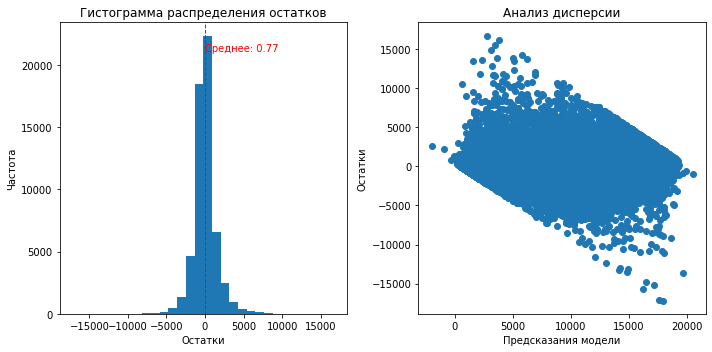

In [76]:
analyze_residuals_variance(best_model_lgbm, y_test, best_model_lgbm.predict(X_test_lgbm))

### Получение важности признаков

             Feature  Importance
6          fuel_type          43
2            gearbox         119
8           repaired         206
0       vehicle_type         402
7              brand         502
5          kilometer         586
1  registration_year        1271
4              model        1397
3              power        1474


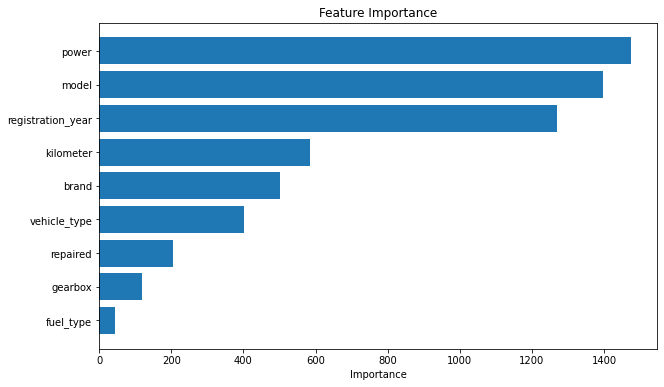

In [77]:
# Получение важности признаков
feature_importances = best_model_lgbm.feature_importances_
feature_names = X.columns  

# Создание DataFrame для отображения
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance')
print(importance_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

__Промежуточный вывод__:
Лучшее значение метрики получено для модели LightGBMRegressor, быстрее всего обучается и тратит наименьшее количество времени на предсказания модель DecisionTreeRegressor, однако значение метрики данной модели намного хуже, чем у других. 

Выбираем LightGBMRegressor, т.к. ее предсказания более точные, адекватное время на обучение и получение предсказаний. 

Наша модель показывает на тестовой выборке результат лучше, чем DummyRegressor, RMSE на тестовой выборке 1545.03 против 4648.22.

График остатков модели симметричен относительно нуля (среднее очень близко к нулю, с учетом масштаба предсказаний), имеет одну вершину, распределение по форме похоже на нормальное. Вместе с этим видим неравномерность дисперсии остатков. Модель работает по-разному для различных диапазонов значений, ее можно улучшить.

Наибольший вклад в предсказание модели вносят значение мощности, модель и год регистрации автомобиля, наименьшее - тип топлива.

## Вывод

Мы загрузили и проанализировали данные о технических характеристиках, комплектации и ценах автомобилей. В данных было большое число дубликатов (полных и неявных), аномалий и нетипичных для датасета значений. Также мы удалили неинформативные признаки (date_crawled, date_created, last_seen, postal_code, registration_month, number_of_pictures).  После очистки размер датасета сократился 33.8% и составил 234524 записи, 10 признаков. С учетом достаточного количества записей в изначальном датасете мы так сильно сократили датасет с целью повышения качества данных. Далее мы провели корреляционный анализ данных, убедились в наличии взаимосвязи между выбранными признаками.

Обучили модели CatBoostRegressor, LGBMRegressor, DecisionTreeRegressor с различными гиперпараметрами, определили гиперпараметры моделей с наименьшей метрикой RMSE. Для каждой модели вычислили время обучения и получения предсказаний. 

Лучшее значение метрики получено для модели LightGBMRegressor, быстрее всего обучается и тратит наименьшее количество времени на предсказания модель DecisionTreeRegressor, однако значение метрики данной модели намного хуже, чем у других. Выбираем __LightGBMRegressor с параметрами 'max_depth': 8, 'n_estimators': 200, 'random_state': 42__, т.к. ее предсказания более точные, адекватное время на обучение и получение предсказаний. 

Выбранная модель на тестовой выборке показывает __RMSE 1545.03__, результат лучше, чем у DummyRegressor (RMSE 4648.22).
Наибольший вклад в предсказание модели вносят значение мощности, модель и год регистрации автомобиля, наименьшее - тип топлива.

При анализе моделей заметили неравномерность дисперсии остатков. Можно попробовать улучшить модель:
- введение новых признаков (класс автомобиля и др.),
- подбор гиперпараметров из более широкого диапазона,
- использование других моделей.